In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
def forward_impl(ctx, x):
    ctx.save_for_backward(x)
    y = x / 6.0 + 0.5
    y[x <= -3] = 0.0
    y[x >= 3] = 1.0
    return y
    
class _HardSigmoid_A(torch.autograd.Function):
    forward = staticmethod(forward_impl)
    
    @staticmethod
    def backward(ctx, dy, *args):
        x = ctx.saved_tensors[0]
        dx = dy.clone()
        dx = dx / 6.0
        dx[x <= -3.0] = 0.0
        dx[x >= 3.0] = 0.0
        return dx
        

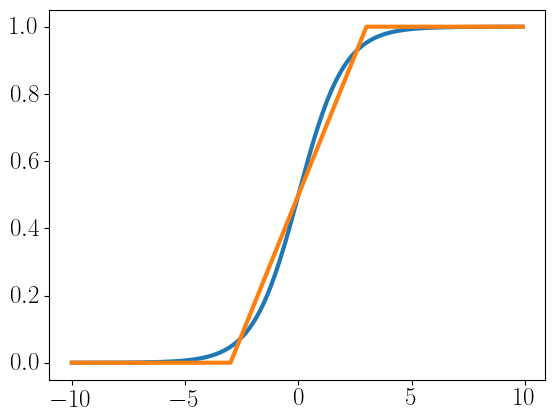

In [4]:
class Sigmoid(nn.Module):
    def forward(self, x, *args):
        return 1.0 / (1.0 + torch.exp(-x))
    
class HardSigmoidA(nn.Module):
    def forward(self, x, *args):
        return _HardSigmoid_A.apply(x)
        

sigmoid = Sigmoid()
hardsigmoid = HardSigmoidA()

x = torch.arange(-10, 10, 0.1).requires_grad_()
y = sigmoid(x)
hy = hardsigmoid(x)

xnp = x.detach().numpy()
ynp = y.detach().numpy()
hynp = hy.detach().numpy()

plt.plot(xnp, ynp)
plt.plot(xnp, hynp)

In [5]:
loss = nn.MSELoss()

hardsigmoid.train()
y = hardsigmoid(x)
z = y.sum() + 0.0
z.backward()


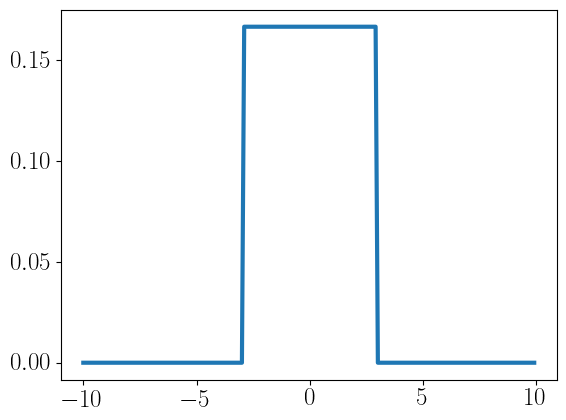

In [6]:
plt.plot(xnp, x.grad)

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(4, 4)
        self.activation = Sigmoid()
        self.layer2 = nn.Linear(4, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

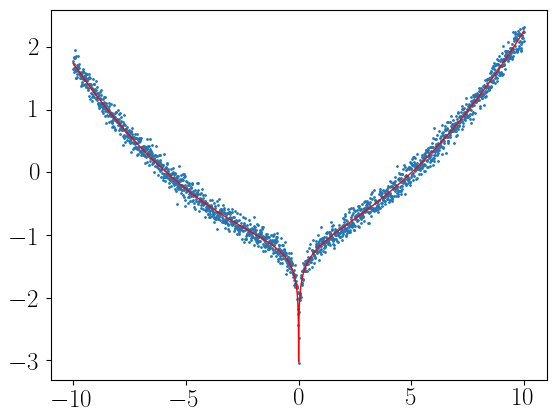

In [8]:
xx = torch.arange(-10, 10, 0.01)
xx[xx == 0] += 1e-3
yy = 3.3 * xx + 3.3 * xx * xx + 33.33 * xx.abs().log()
yy -= yy.mean()
yy /= yy.std()
y_noise = torch.randn(yy.shape) * 0.1

y_data = yy + y_noise

plt.scatter(xx, y_data, s=1)
plt.plot(xx, yy, lw=1, c='r')

In [9]:
x_data = torch.stack([xx, xx*xx, xx.exp(), xx.abs().log() + 1e-3], 1)
def preprocess(x, y):
    return x / x.max(0).values, y.unsqueeze(-1)

In [10]:
model = SimpleModel()
optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100)
loss = nn.MSELoss()

In [11]:
import math

epochs = 5000
batch_size = 100
device = 'cuda'

xxx, yyy = preprocess(x_data, y_data)

for epoch in range(epochs):
    optimizer.zero_grad()
    yyy_hat = model(xxx)

    ls = loss(yyy_hat, yyy)
    ls.backward()
    optimizer.step()
    scheduler.step(epoch)
    if math.isnan(ls):
        print("BROKE on epoch", epoch, ls)
        break
    
    if (epoch + 1) % 50 == 0:
        print(f'{epoch+1} Loss: {ls.item()}')


50 Loss: 0.01744534820318222
100 Loss: 0.01396365836262703
150 Loss: 0.01234712079167366
200 Loss: 0.012101329863071442
250 Loss: 0.011625764891505241
300 Loss: 0.011453304439783096
350 Loss: 0.011108615435659885
400 Loss: 0.010982870124280453
450 Loss: 0.010772430337965488
500 Loss: 0.010695653036236763
550 Loss: 0.010580715723335743
600 Loss: 0.010533841326832771
650 Loss: 0.010468357242643833
700 Loss: 0.01043644268065691
750 Loss: 0.01039501465857029
800 Loss: 0.010370582342147827
850 Loss: 0.010341176763176918
900 Loss: 0.010320759378373623
950 Loss: 0.01029809657484293
1000 Loss: 0.010280086658895016
1050 Loss: 0.010261778719723225
1100 Loss: 0.010245374403893948
1150 Loss: 0.010230247862637043
1200 Loss: 0.010215011425316334
1250 Loss: 0.01020229421555996
1300 Loss: 0.010187961161136627
1350 Loss: 0.010177182033658028
1400 Loss: 0.01016357634216547
1450 Loss: 0.010154166258871555
1500 Loss: 0.010141157545149326
1550 Loss: 0.010132997296750546
1600 Loss: 0.010120518505573273
1650

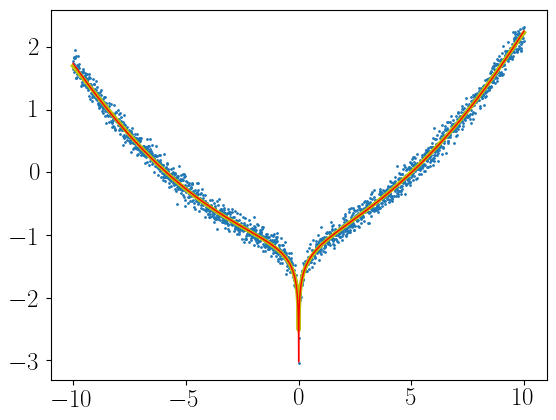

In [12]:
plt.scatter(xx, y_data, s=1)
plt.plot(xx, yyy_hat.detach(), c='y')
plt.plot(xx, yy, lw=1, c='r')


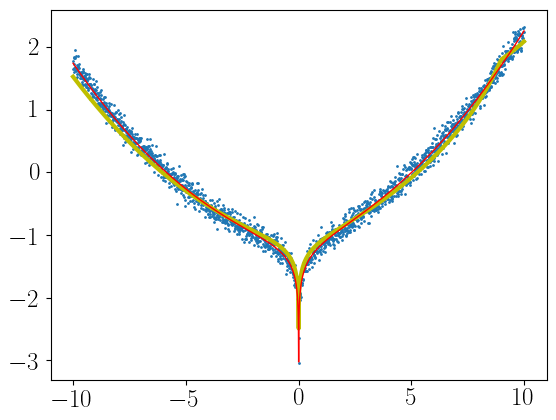

In [13]:
model.activation = HardSigmoidA()
yyy_a = model(xxx)

plt.scatter(xx, y_data, s=1)
plt.plot(xx, yyy_a.detach(), c='y')
plt.plot(xx, yy, lw=1, c='r')


In [19]:
ls = loss(yyy_a, yy.squeeze())
print(ls)

tensor(1.8807, grad_fn=<MseLossBackward>)


In [ ]:
# Training with hardsigmoid

In [20]:
model = SimpleModel()
model.activation = HardSigmoidA()
optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100)
loss = nn.MSELoss()

In [21]:
import math

epochs = 5000
batch_size = 100
device = 'cuda'

xxx, yyy = preprocess(x_data, y_data)

for epoch in range(epochs):
    optimizer.zero_grad()
    yyy_hat_a = model(xxx)

    ls = loss(yyy_hat_a, yyy)
    ls.backward()
    optimizer.step()
    scheduler.step(epoch)
    if math.isnan(ls):
        print("BROKE on epoch", epoch, ls)
        break
    
    if (epoch + 1) % 50 == 0:
        print(f'{epoch+1} Loss: {ls.item()}')


50 Loss: 0.3025699853897095
100 Loss: 0.11546095460653305
150 Loss: 0.012829050421714783
200 Loss: 0.012155442498624325
250 Loss: 0.011551633477210999
300 Loss: 0.011419510468840599
350 Loss: 0.011227358132600784
400 Loss: 0.011151526123285294
450 Loss: 0.011050249449908733
500 Loss: 0.011007320135831833
550 Loss: 0.010937919840216637
600 Loss: 0.010904821567237377
650 Loss: 0.010851990431547165
700 Loss: 0.010824864730238914
750 Loss: 0.010781511664390564
800 Loss: 0.010759774595499039
850 Loss: 0.010724385268986225
900 Loss: 0.010707460343837738
950 Loss: 0.010678477585315704
1000 Loss: 0.010663002729415894
1050 Loss: 0.010634069330990314
1100 Loss: 0.010618460364639759
1150 Loss: 0.010591188445687294
1200 Loss: 0.010576820932328701
1250 Loss: 0.010552357882261276
1300 Loss: 0.010539642535150051
1350 Loss: 0.010518516413867474
1400 Loss: 0.010505728423595428
1450 Loss: 0.0104825459420681
1500 Loss: 0.01046995259821415
1550 Loss: 0.010450097732245922
1600 Loss: 0.010439077392220497
16

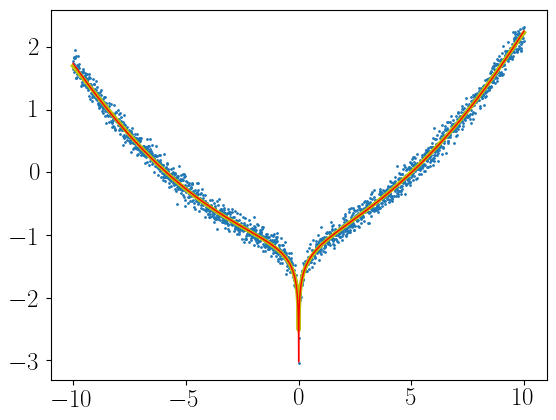

In [24]:
model.activation = HardSigmoidA()
yyy_a = model(xxx)

plt.scatter(xx, y_data, s=1)
plt.plot(xx, yyy_hat.detach(), c='y')
plt.plot(xx, yyy_hat_a.detach(), lw=1, c='r')

In [25]:
ls = loss(yyy_hat_a, yy.squeeze())
print(ls)

tensor(1.9970, grad_fn=<MseLossBackward>)


/home/zafar/miniconda3/envs/py37-ml/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
